In [1]:
import time
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

%matplotlib inline 
plt.style.use('seaborn-pastel')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
calendar = pd.read_csv("../data/calendar.csv")
sales_train_evaluation = pd.read_csv("../data/sales_train_evaluation.csv")
sales_train_validation = pd.read_csv("../data/sales_train_validation.csv")
sell_prices = pd.read_csv("../data/sell_prices.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
sales_train_evaluation["demand"] = sales_train_evaluation.iloc[:,6:].sum(axis=1)
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,demand
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1

In [4]:
item_demand = sales_train_evaluation[["item_id","demand"]].groupby(["item_id"]).agg(['sum','mean','median','std']).reset_index()
item_demand.columns = ['item_id','sum','mean','median','std']
item_demand.dropna().sort_values(by=['std'],ascending=False).head()

,item_id,sum,mean,median,std
702,FOODS_3_090,1017916,101791.6,105912.0,65409.884580
1198,FOODS_3_586,932236,93223.6,87922.5,56181.032227
864,FOODS_3_252,573723,57372.3,57809.0,33425.437885
838,FOODS_3_226,368369,36836.9,21949.0,33400.943761
732,FOODS_3_120,290132,29013.2,15854.5,27980.523769


In [5]:
store_demand = sales_train_evaluation[["store_id","demand"]].groupby(["store_id"]).agg(['sum','mean','median','std']).reset_index()
store_demand.columns = ['store_id','sum','mean','median','std']
store_demand.dropna().sort_values(by=['std'],ascending=False).head()

,store_id,sum,mean,median,std
2,CA_3,11363540,3726.972778,1505,8581.106514
5,TX_2,7329642,2403.949492,927,6505.105845
9,WI_3,6542557,2145.804198,727,5565.160045
6,TX_3,6205940,2035.401771,741,5518.222694
0,CA_1,7832248,2568.792391,1149,5422.759182


In [85]:
selected_ids = ["CA_3"]
#selected_ids = ["FOODS_3_090_CA_3_evaluation"]

partial_data = sales_train_evaluation[sales_train_evaluation["store_id"] == selected_ids[0]]
for i in selected_ids[1:]:
    tmp = sales_train_evaluation[sales_train_evaluation["store_id"] == i]
    partial_data = pd.concat([partial_data,tmp])
print(partial_data.shape)
partial_data.head()

(3049, 1948)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,demand
6098,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,1,1,2,1,1,0,2,0,0,1,2,0,0,0,1,2,0,0,2,0,0,0,1,2,2,1,1,0,2,0,0,1,1,2,0,0,2,1,0,2,0,3,0,2,1,1,0,0,2,1,5,0,0,0,0,1,1,5,3,0,0,0,0,0,0,0,0,0,1,1,3,1,1,0,1,1,1,1,2,2,0,0,0,0,0,0,0,0,0,1,3,0,0,0,5,0,1,0,0,6,0,0,2,0,0,0,0,0,0,0,1,1,3,2,0,0,0,0,1,0,0,0,0,

In [86]:
df_melt = pd.melt(partial_data, id_vars=partial_data.columns[:6], value_vars=partial_data.columns[6:-1], var_name = 'd', value_name = 'demand')

In [87]:
df_melt.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
5918104,FOODS_3_823_CA_3_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_3,CA,d_1941,2
5918105,FOODS_3_824_CA_3_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_3,CA,d_1941,0
5918106,FOODS_3_825_CA_3_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_3,CA,d_1941,1
5918107,FOODS_3_826_CA_3_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_3,CA,d_1941,0
5918108,FOODS_3_827_CA_3_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_3,CA,d_1941,0


In [88]:
partial_cal = calendar[["d","weekday","month","year","event_name_1","event_name_2","date"]].fillna("--")
df_merge = pd.merge(df_melt[['d','id','item_id','store_id','demand']], partial_cal)
print(df_merge.shape)
df_merge.tail()

(5918109, 11)


,d,id,item_id,store_id,demand,weekday,month,year,event_name_1,event_name_2,date
5918104,d_1941,FOODS_3_823_CA_3_evaluation,FOODS_3_823,CA_3,2,Sunday,5,2016,--,--,2016-05-22
5918105,d_1941,FOODS_3_824_CA_3_evaluation,FOODS_3_824,CA_3,0,Sunday,5,2016,--,--,2016-05-22
5918106,d_1941,FOODS_3_825_CA_3_evaluation,FOODS_3_825,CA_3,1,Sunday,5,2016,--,--,2016-05-22
5918107,d_1941,FOODS_3_826_CA_3_evaluation,FOODS_3_826,CA_3,0,Sunday,5,2016,--,--,2016-05-22
5918108,d_1941,FOODS_3_827_CA_3_evaluation,FOODS_3_827,CA_3,0,Sunday,5,2016,--,--,2016-05-22


In [89]:
def lags_windows(df):
    lags = [7]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","demand"]].groupby("id")["demand"].shift(lag)

    wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def per_timeframe_stats(df, col):
    #For each item compute its mean and other descriptive statistics for each month and dayofweek in the dataset
    months = df['month'].unique().tolist()
    for y in months:
        df.loc[df['month'] == y, col+'_month_mean'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['month'] == y, col+'_month_max'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
        df.loc[df['month'] == y, col+'_month_min'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.min()).astype("float32")
        df[col + 'month_max_to_min_diff'] = (df[col + '_month_max'] - df[col + '_month_min']).astype("float32")

    dayofweek = df['weekday'].unique().tolist()
    for y in dayofweek:
        df.loc[df['weekday'] == y, col+'_dayofweek_mean'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['weekday'] == y, col+'_dayofweek_median'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.median()).astype("float32")
        df.loc[df['weekday'] == y, col+'_dayofweek_max'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
    return df

def feat_eng(df):
    df = lags_windows(df)
    df = per_timeframe_stats(df,'demand')
    return df

In [90]:
data = df_merge.copy()
data['date'] = pd.to_datetime(data['date'])


# rolling demand features
data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
data['rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())

data = feat_eng(data)

In [91]:
useless_cols = ['d','id','date','demand']
lgb_train_cols = data.columns[~data.columns.isin(useless_cols)]
linreg_train_cols = lgb_train_cols#['sell_price','year','month','dayofweek','lag_7','rmean_7_7'] #use different columns for linear regression


from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
data['item_id'] = lbl.fit_transform(data['item_id'].astype(str))
data['store_id'] = lbl.fit_transform(data['store_id'].astype(str))
data['weekday'] = lbl.fit_transform(data['weekday'].astype(str))
data['event_name_1'] = lbl.fit_transform(data['event_name_1'].astype(str))
data['event_name_2'] = lbl.fit_transform(data['event_name_2'].astype(str))
data = data.dropna(0)

train = data[data['date'] <= '2016-03-27']
test = data[(data['date'] > '2016-03-11') & (data['date'] <= '2016-04-24')]

X_train = train[lgb_train_cols].copy()
y_train = train["demand"]

X_test = test[lgb_train_cols].copy()
y_test = test["demand"]

## Fit Models

In [92]:
#Fit Light Gradient Boosting
t0 = time.time()
lgb_params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
        'num_iterations' : 2000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}
np.random.seed(777)
fake_valid_inds = np.random.choice(X_train.index.values, 365, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],free_raw_data=False)

m_lgb = lgb.train(lgb_params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 
t_lgb = time.time()-t0

#Fit Linear Regression
t0 = time.time()
m_linreg = LinearRegression().fit(X_train[linreg_train_cols].loc[train_inds], y_train.loc[train_inds])
t_linreg = time.time()-t0

#Fit Random Forest
t0 = time.time()
m_rf = RandomForestRegressor(n_estimators=100,max_depth=5, random_state=26, n_jobs=-1).fit(X_train.loc[train_inds], y_train.loc[train_inds])
t_rf = time.time()-t0

[LightGBM] [Info] Total Bins 4379
[LightGBM] [Info] Number of data points in the train set: 3897230, number of used features: 26
[LightGBM] [Info] Start training from score 0.935665
[20]	valid_0's rmse: 3.79068
[40]	valid_0's rmse: 6.51797
[60]	valid_0's rmse: 7.83597
[80]	valid_0's rmse: 8.48268
[100]	valid_0's rmse: 8.78184
[120]	valid_0's rmse: 8.9343
[140]	valid_0's rmse: 8.76184
[160]	valid_0's rmse: 8.77848
[180]	valid_0's rmse: 8.7056
[200]	valid_0's rmse: 8.7313
[220]	valid_0's rmse: 8.60932
[240]	valid_0's rmse: 8.49103
[260]	valid_0's rmse: 8.48111
[280]	valid_0's rmse: 8.51748
[300]	valid_0's rmse: 8.28437
[320]	valid_0's rmse: 8.22985
[340]	valid_0's rmse: 8.11018
[360]	valid_0's rmse: 7.97326
[380]	valid_0's rmse: 7.78745
[400]	valid_0's rmse: 7.86976
[420]	valid_0's rmse: 7.84751
[440]	valid_0's rmse: 7.65785
[460]	valid_0's rmse: 7.40016
[480]	valid_0's rmse: 7.18079
[500]	valid_0's rmse: 7.16701
[520]	valid_0's rmse: 7.06896
[540]	valid_0's rmse: 6.96967
[560]	valid_0's

In [93]:
fday = datetime(2016,3, 28) 
max_lags = 15
for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    tst = test[(test.date >= day - timedelta(days=max_lags)) & (test.date <= day)].copy()
    #tst = feat_eng(tst)
    tst_lgb = tst.loc[tst.date == day , lgb_train_cols].copy()
    test.loc[test.date == day, "preds_LightGB"] = m_lgb.predict(tst_lgb)
    tst_rf = tst.loc[tst.date == day , lgb_train_cols].copy()
    tst_rf = tst_rf.fillna(0) 
    test.loc[test.date == day, "preds_RandomForest"] = m_rf.predict(tst_rf)
    
    tst_linreg = tst.loc[tst.date == day , linreg_train_cols].copy()
    tst_linreg = tst_linreg.fillna(0)    
    test.loc[test.date == day, "preds_LinearReg"] = m_linreg.predict(tst_linreg) 
    
test_final = test.loc[test.date >= fday]

## Light Gradient Boosting

In [94]:
predictions = test[["id","date"]]
stats = pd.DataFrame(columns=['Model Name','Execution Time','RMSE'])
selected_ids = ["FOODS_3_090_CA_3_evaluation"]

RMSE for LightGB: 2.6850


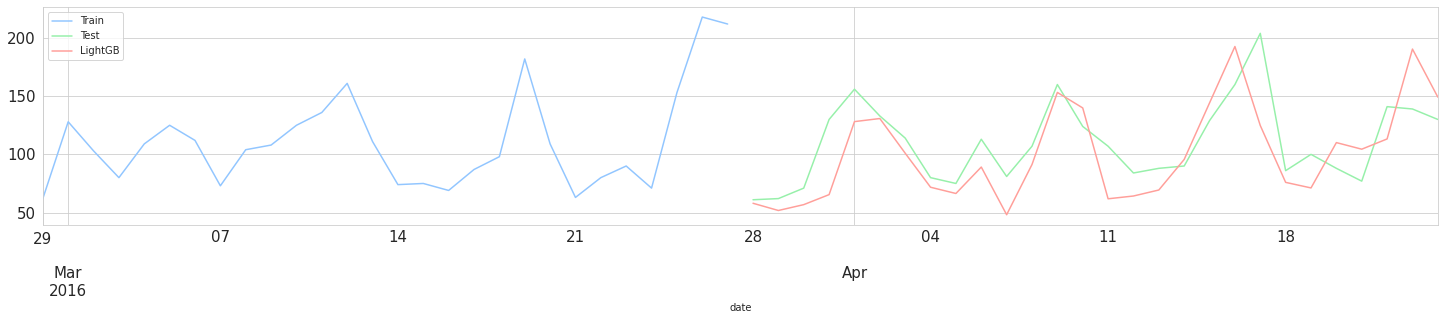

In [95]:
model_name='LightGB'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[train["id"] == selected_ids[0]][-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='demand',label='Test',ax=ax);
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='preds_LightGB',label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(test_final['preds_LightGB'], test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_lgb, 'RMSE':score},ignore_index=True)

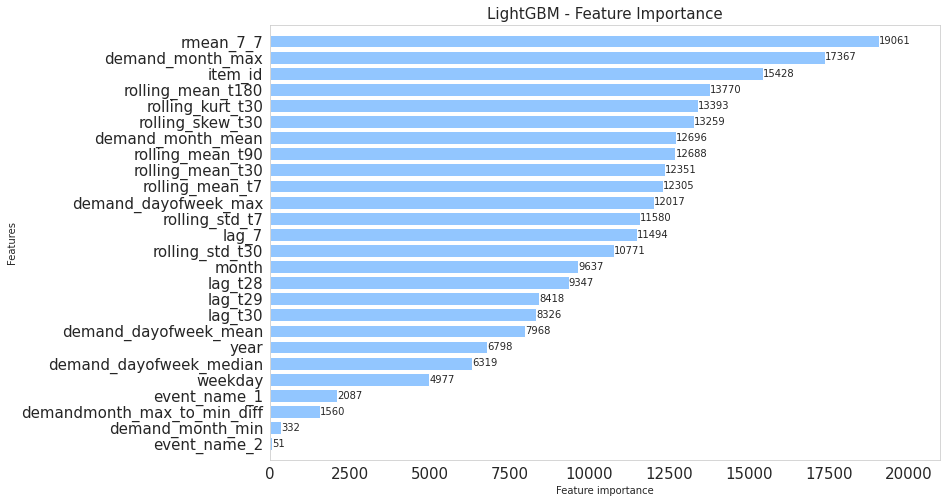

In [96]:
fig, ax = plt.subplots(figsize=(12,8)) #
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Random Forest

RMSE for RandomForest: 2.7562


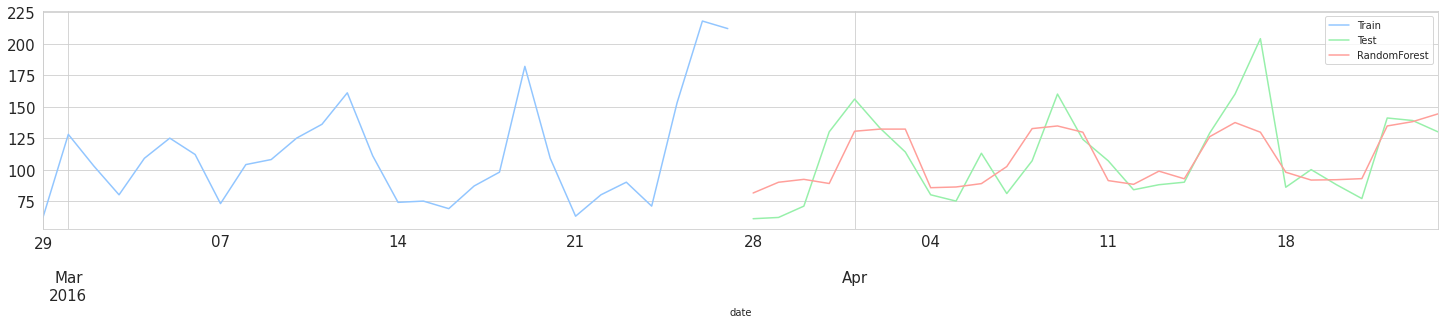

In [97]:
model_name='RandomForest'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[train["id"] == selected_ids[0]][-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='demand',label='Test',ax=ax);
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='preds_RandomForest',label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(test_final['preds_RandomForest'], test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_lgb, 'RMSE':score},ignore_index=True)

## Linear Regression

RMSE for LinearReg: 2.7847


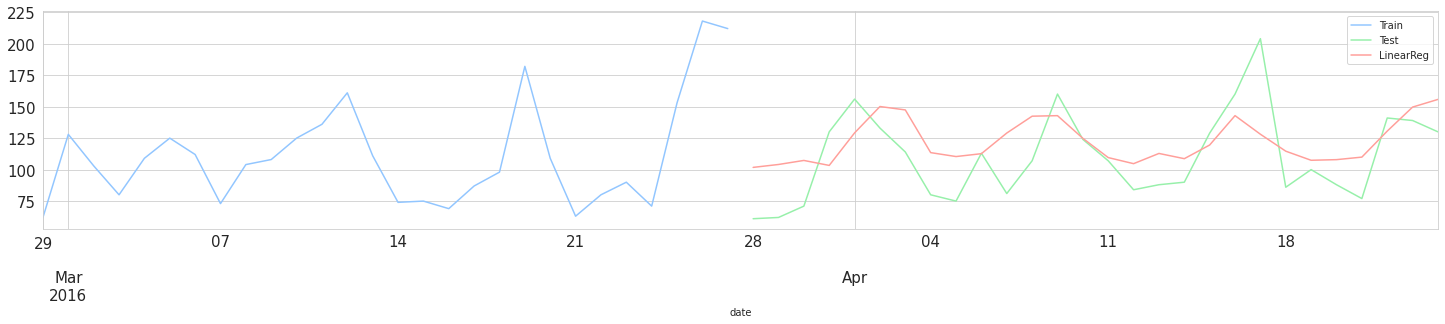

In [98]:
model_name='LinearReg'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[train["id"] == selected_ids[0]][-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='demand',label='Test',ax=ax);
test_final[test_final["id"] == selected_ids[0]].plot(x='date',y='preds_LinearReg',label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(test_final['preds_LinearReg'], test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_linreg, 'RMSE':score},ignore_index=True)

In [99]:
stats.sort_values(by='RMSE')

,Model Name,Execution Time,RMSE
0,LightGB,92.840536,2.684981
1,RandomForest,92.840536,2.756217
2,LinearReg,5.049808,2.784726


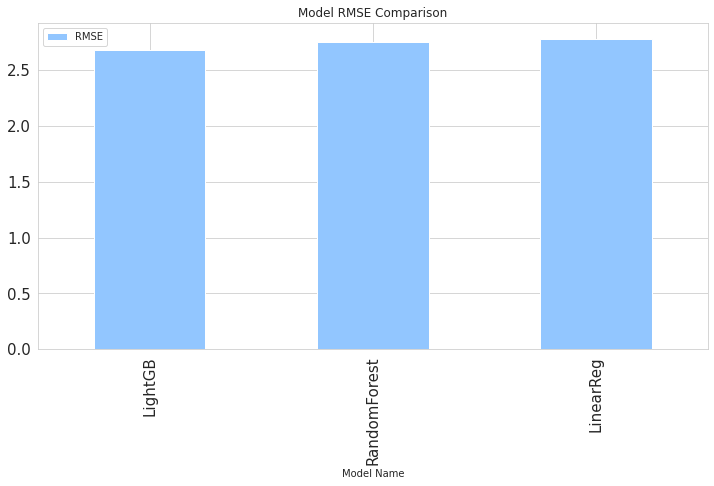

In [103]:
stats.plot(kind='bar',x='Model Name', y='RMSE', figsize=(12,6), title="Model RMSE Comparison");